# Loading data

In [1]:
from keras.datasets.mnist import load_data
(x_train, y_train), (x_test, y_test) = load_data()

In [2]:
print('Train', x_train.shape, y_train.shape)
print('Test', x_test.shape, y_test.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


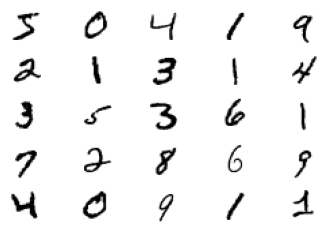

In [3]:
import matplotlib.pyplot as plt

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.axis('off')
    plt.imshow(x_train[i], cmap="gray_r")
plt.show()

# Defining Discriminator Model

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

def discriminator(input_shape=(28, 28, 1)):
    model = keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation="sigmoid"))
    
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

    return model


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

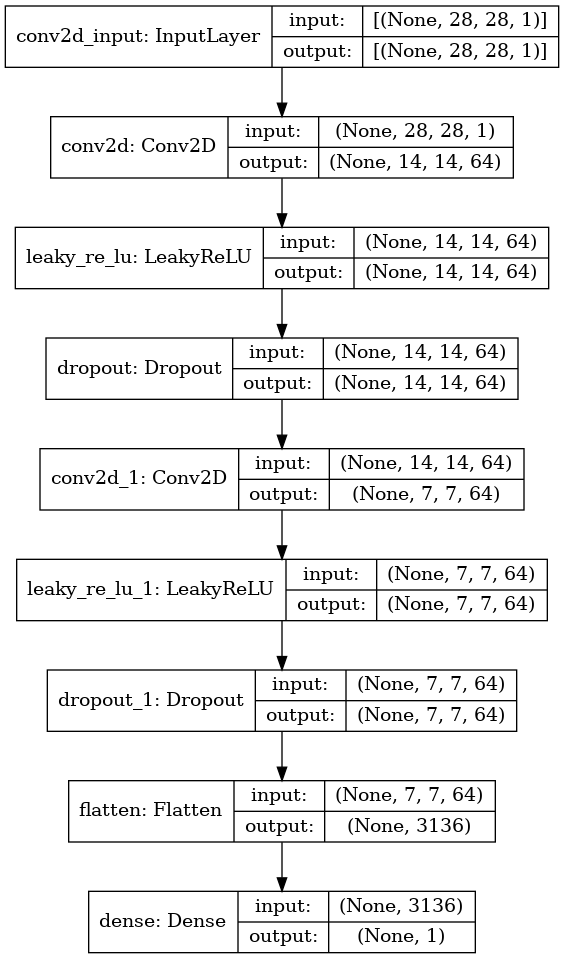

In [5]:
model = discriminator()
model.summary()

from tensorflow.keras.utils import plot_model

plot_model(model, to_file="discriminator.png", show_shapes=True, show_layer_names=True)

In [6]:
import numpy as np

def load_real_samples():

    (x_train, _), (_, _) = load_data()

    # converting 2d image to 3d
    x = np.expand_dims(x_train, axis=-1)

    # converting data type of the image
    x = x.astype("float32")

    # finally normalizing the image
    x = x / 255.0

    return x

def generate_real_samples(dataset, n_samples):
    samples_range = np.random.randint(0, dataset.shape[0], n_samples)
    x = dataset[samples_range]
    y = np.ones((n_samples, 1))
    return x, y

def generate_fake_samples(n_samples):
    x = np.random.rand(28 * 28 * n_samples)
    x = x.reshape((n_samples, 28, 28, 1))
    y = np.zeros((n_samples, 1))
    return x, y


In [7]:
def train_discriminator(model, dataset, n_iter=100, n_batch=2560):
    half_batch = int(n_batch / 2)

    for i in range(n_iter):
        x_real, y_real = generate_real_samples(dataset, half_batch)

        _, real_acc = model.train_on_batch(x_real, y_real)
        x_fake, y_fake = generate_fake_samples(half_batch)
        _, fake_acc = model.train_on_batch(x_fake, y_fake)
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [8]:
dataset = load_real_samples()
train_discriminator(model, dataset)

>1 real=21% fake=72%
>2 real=29% fake=84%
>3 real=30% fake=93%
>4 real=28% fake=97%
>5 real=31% fake=99%
>6 real=31% fake=100%
>7 real=30% fake=100%
>8 real=30% fake=100%
>9 real=32% fake=100%
>10 real=34% fake=100%
>11 real=33% fake=100%
>12 real=35% fake=100%
>13 real=38% fake=100%
>14 real=41% fake=100%
>15 real=41% fake=100%
>16 real=44% fake=100%
>17 real=47% fake=100%
>18 real=52% fake=100%
>19 real=58% fake=100%
>20 real=62% fake=100%
>21 real=68% fake=100%
>22 real=73% fake=100%
>23 real=76% fake=100%
>24 real=82% fake=100%
>25 real=83% fake=100%
>26 real=87% fake=100%
>27 real=89% fake=100%
>28 real=93% fake=100%
>29 real=95% fake=100%
>30 real=95% fake=100%
>31 real=97% fake=100%
>32 real=97% fake=100%
>33 real=98% fake=100%
>34 real=99% fake=100%
>35 real=99% fake=100%
>36 real=100% fake=100%
>37 real=100% fake=100%
>38 real=100% fake=100%
>39 real=100% fake=100%
>40 real=100% fake=100%
>41 real=100% fake=100%
>42 real=100% fake=100%
>43 real=100% fake=100%
>44 real=100% fak

# Designing Generator Model

In [11]:
def generator_model(latent_dim):
    model = keras.Sequential()
    n_nodes = 128 * 7 * 7
    model.add(layers.Dense(n_nodes, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((7, 7, 128)))

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(1, (7, 7), activation="sigmoid", padding="same"))

    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 28, 28, 128)      

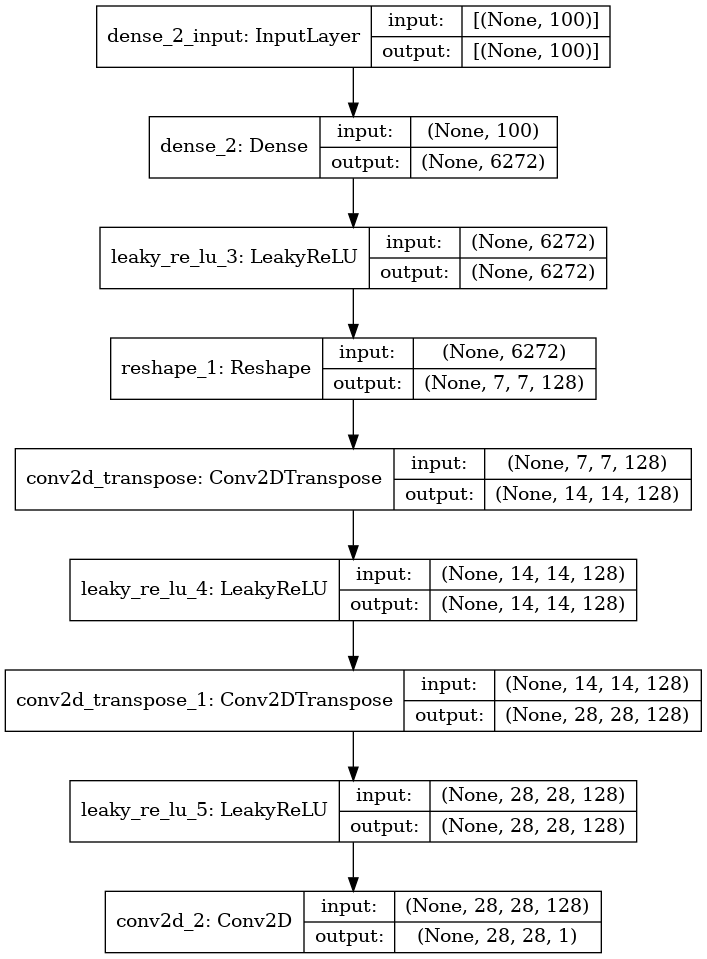

In [12]:
latent_dim = 100
model = generator_model(latent_dim)
model.summary()
plot_model(model, to_file="generator_plot.png", show_shapes=True, show_layer_names=True)

In [15]:
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples_by_generator(model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    x = model.predict(x_input)
    y = np.zeros((n_samples, 1))
    return x, y

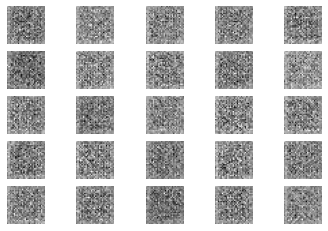

In [23]:
n_samples = 25
x, _ = generate_fake_samples_by_generator(model, latent_dim, n_samples)

for i in range(n_samples):
    plt.subplot(5, 5, i + 1)
    plt.axis('off')
    plt.imshow(x[i, :, :, 0], cmap='gray_r')

plt.show()

In [17]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = keras.Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt)
    return model

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


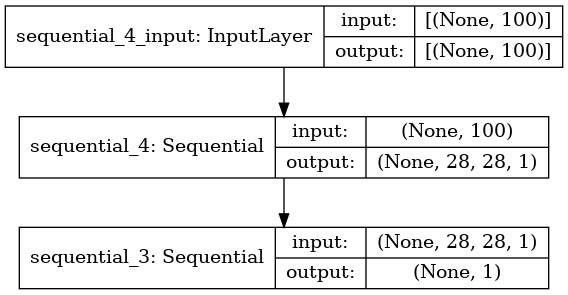

In [18]:
latent_dim = 100
d_model = discriminator()
g_model = generator_model(latent_dim)

gan_model = define_gan(g_model, d_model)
gan_model.summary()

plot_model(gan_model, to_file="gan_plot.png", show_shapes=True, show_layer_names=True)

In [19]:
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):
    for i in range(n_epochs):
        x_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = np.ones((n_batch, 1))
        gan_model.train_on_batch(x_gan, y_gan)

In [26]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

In [25]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples_by_generator(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

    save_plot(x_fake, epoch)

    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)
    

In [24]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):
        for j in range(bat_per_epo):
            x_real, y_real = generate_real_samples(dataset, half_batch)
            x_fake, y_fake = generate_fake_samples_by_generator(g_model, latent_dim, half_batch)
            x, y = np.vstack((x_real, x_fake)), np.vstack((y_real,y_fake))
            d_loss, _ = d_model.train_on_batch(x, y)
            x_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))

            gan_loss = gan_model.train_on_batch(x_gan, y_gan)
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, gan_loss))
        
        if (i + 1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)